In [54]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_handler import CoinDataStore
from src.simple_wash_detector_utils import detect_wash_trades_nearest

import warnings
warnings.filterwarnings("ignore")

In [55]:
store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
sells = df_all_matched[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
sells["is_ask"] = True

buys = df_all_matched[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
buys["is_ask"] = False

df_all = pd.concat([sells, buys], ignore_index=True)

df_all["notional"] = df_all["price"] * df_all["size"]
df_all = df_all.groupby(["wallet_id", "time", "is_ask"]).agg(size=("size", "sum"), notional=("notional", "sum")).reset_index()
df_all["price"] = (df_all["notional"] / df_all["size"]).astype("float32")
df_all = df_all.drop("notional", axis=1)

### No filtration

In [58]:
store = CoinDataStore("AVAX", engine="fastparquet")
time_diff_s = 5 * 60 # 10 minutes difference
price_diff_pct = 0.01
size_diff_pct = 0.01

df_detected = detect_wash_trades_nearest(store, time_diff_s, price_diff_pct, size_diff_pct, is_final_filtration=False)
df_detected_no_filtr = df_detected.copy()

print(f"Wash trading takes {(df_detected["open_size"] * df_detected["open_price"]).sum() * 2 / (df_all_matched["size"] * df_all_matched["price"]).sum() * 100} % of overall volume.")
print(f"Wash trading takes {df_detected["open_size"].shape[0] * 2 / df_all_matched.shape[0] * 100} % of overall trades.")

Wash trading takes 5.862912654876709 % of overall volume.
Wash trading takes 5.190472228254142 % of overall trades.


### With filtration

In [59]:
store = CoinDataStore("AVAX", engine="fastparquet")
time_diff_s = 5 * 60 # 10 minutes difference
price_diff_pct = 0.01
size_diff_pct = 0.01

df_detected = detect_wash_trades_nearest(store, time_diff_s, price_diff_pct, size_diff_pct)
print(f"Wash trading takes {(df_detected["open_size"] * df_detected["open_price"]).sum() * 2 / (df_all_matched["size"] * df_all_matched["price"]).sum() * 100} % of overall volume.")
print(f"Wash trading takes {df_detected["open_size"].shape[0] * 2 / df_all_matched.shape[0] * 100} % of overall trades.")

Wash trading takes 5.229082107543945 % of overall volume.
Wash trading takes 4.9837408768629325 % of overall trades.


In [24]:
df_detected_no_filtr["open_size"].sum(), df_detected["open_size"].sum()

(np.float32(1085461.5), np.float32(665552.3))

In [25]:
df_detected_no_filtr.shape[0], df_detected.shape[0]

(21791, 17886)

In [50]:
t = df_detected_no_filtr[~df_detected_no_filtr["wallet_id"].isin(df_detected["wallet_id"].unique())].groupby("wallet_id").agg(
    {"open_size": ["sum", "count"]}).sort_values(('open_size',   'sum'), ascending=False).head(10)
t["proportion"] = t[('open_size',   'sum')] / t[('open_size',   'count')]
t

open_size          proportion
                    sum count              
wallet_id                                  
161        94905.132812   587    161.678250
26156      40180.519531   205    196.002534
480        29866.369141   107    279.124945
892        21013.150391   119    176.581096
13372      20000.000000     1  20000.000000
22         18735.179688   322     58.183788
1844       16688.599609     8   2086.074951
23         11478.250000   221     51.937783
658        11455.040039    11   1041.367276
534        10537.610352    51    206.619811

In [53]:
df_detected["open_size"].sum() / df_detected["open_size"].count()

np.float64(37.210796852286705)

In [44]:
df_all[~df_all["wallet_id"].isin(df_detected["wallet_id"].unique())].groupby("wallet_id").agg({"size": ["sum", "count"]}).sort_values(('size',   'sum'), ascending=False).head(10)

size        
                 sum   count
wallet_id                   
161        9530737.0  139051
22         6973105.0   79578
13372      6594980.5    1067
534        5635417.0   39258
892        5206099.5   76675
480        5008946.0   29159
1621       4919995.5   25035
19         4486441.5  189043
8          4276013.0  170994
1844       4046746.0    3413

In [17]:
def plot_volume_histogram(df, size_col="size", bins=30):
    """
    Plot a histogram of trade sizes where bar heights represent total volume
    (sum of sizes) per bin.
    """
    sizes = df[size_col].values

    # Step 1: compute bin edges
    bin_edges = np.linspace(sizes.min(), sizes.max(), bins + 1)

    # Step 2: assign each trade to a bin
    bin_idx = np.digitize(sizes, bin_edges) - 1  # convert to 0-based index

    # Step 3: compute total volume per bin
    volume_per_bin = np.zeros(bins)
    for i, s in zip(bin_idx, sizes):
        if 0 <= i < bins:
            volume_per_bin[i] += s

    # Step 4: plot
    plt.figure(figsize=(10, 5))
    plt.bar(
        (bin_edges[:-1] + bin_edges[1:]) / 2,  # bin centers
        volume_per_bin,
        width=(bin_edges[1] - bin_edges[0]) * 0.9,
        align="center",
    )
    plt.xlabel("Trade Size")
    plt.ylabel("Total Volume in Bin")
    plt.title("Volume-Weighted Histogram of Trade Sizes")
    plt.grid(True, alpha=0.2)
    plt.show()


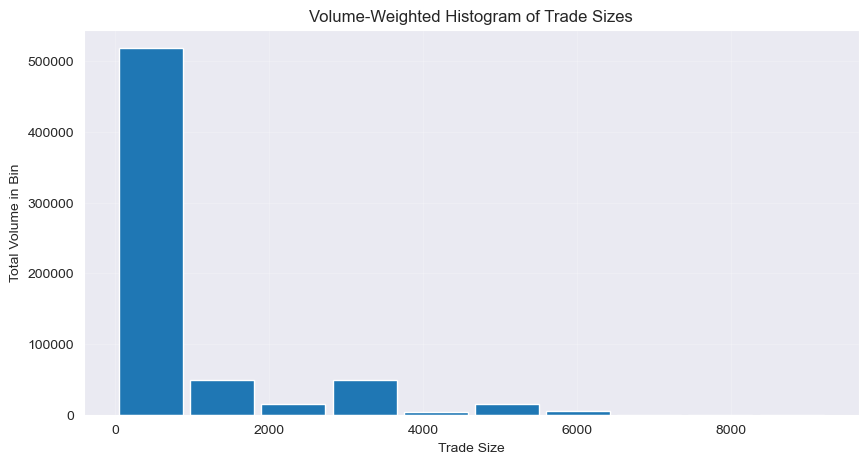

In [18]:
plot_volume_histogram(df_detected, size_col="open_size", bins=10)

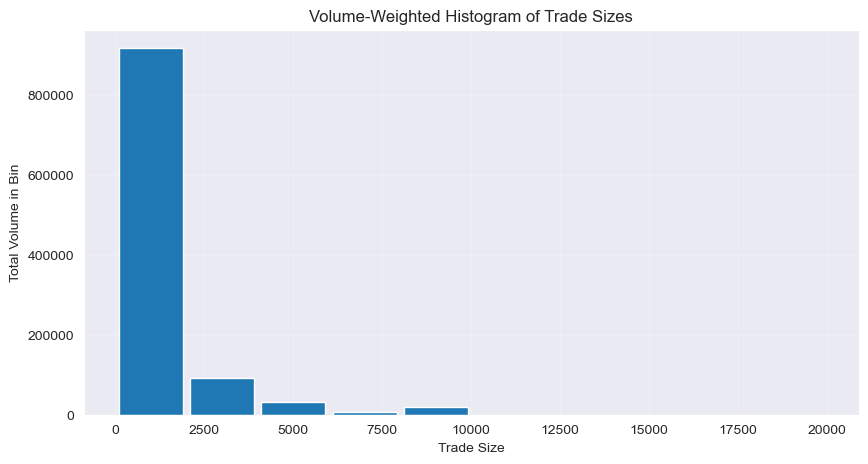

In [19]:
plot_volume_histogram(df_detected_no_filtr, size_col="open_size", bins=10)

In [45]:
df_check = df_detected.sort_values("duration_s").reset_index(drop=True)
df_check

,wallet_id,day,open_time,close_time,duration_s,open_side,close_side,open_price,close_price,price_change_pct,open_size,close_size,size_change_pct,pairing_direction,pair_id
0,626,2025-06-16,2025-06-16 22:37:52.850,2025-06-16 22:37:52.850,0.0,buy,sell,19.671000,19.670000,0.000051,19.000000,19.000000,0.000000,buy_to_sell,15241
1,7220,2025-04-12,2025-04-12 14:24:23.600,2025-04-12 14:24:23.600,0.0,buy,sell,19.836000,19.829000,0.000353,20.290001,20.290001,0.000000,buy_to_sell,4198
2,75651,2025-06-08,2025-06-08 16:32:05.400,2025-06-08 16:32:05.400,0.0,buy,sell,20.885000,20.884001,0.000048,0.570000,0.570000,0.000000,buy_to_sell,13839
3,75651,2025-06-08,2025-06-08 22:26:00.250,2025-06-08 22:26:00.250,0.0,buy,sell,21.216999,21.215000,0.000094,0.480000,0.480000,0.000000,buy_to_sell,13840
4,3425,2025-05-25,2025-05-25 22:11:37.900,2025-05-25 22:11:37.900,0.0,buy,sell,22.823000,22.818001,0.000219,0.450000,0.450000,0.000000,buy_to_sell,11403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17881,19508,2025-04-26,2025-04-26 02:29:15.600,2025-04-26 02:30:15.600,60.0,buy,sell,22.841999,22.834000,0.000350,21.879999,21.900000,0.000914,buy_to_sell,5914
17882,190669,2025-07-20,2025-07-20 15:29:03.950,2025-07-20 15:30:03.950,60.0,buy,sell,25.256001,25.243999,0.000475,7.020000,7.020000,0.000000,buy_to_sell,20495
17883,115,2025-06-21,2025-06-21 18:47:36.400,2025-06-21 18:48:36.400,60.0,sell,buy,16.865000,16.856001,0.000534,29.650000,29.660000,0.000337,sell_to_buy,16050
17884,685,2025-06-13,2025-06-13 01:07:16.950,2025-06-13 01:08:16.950,60.0,sell,buy,19.083000,19.028999,0.002830,23.980000,23.980000,0.000000,sell_to_buy,14912


In [46]:
i = 0
indexes_to_check = np.astype((np.floor(np.linspace(0, len(df_detected[df_detected["open_size"] > 100]) - 1, num=10))), "int", )

In [47]:
df_check[df_check["open_size"] > 100].iloc[[indexes_to_check[i] + 0]]

,wallet_id,day,open_time,close_time,duration_s,open_side,close_side,open_price,close_price,price_change_pct,open_size,close_size,size_change_pct,pairing_direction,pair_id
22,49838,2025-07-04,2025-07-04 16:21:15.600,2025-07-04 16:21:15.600,0.0,sell,buy,17.51,17.497999,0.000685,171.360001,171.350006,0.000058,sell_to_buy,17837


In [48]:
df_all_matched[
    (df_all_matched["time"] >= df_check.at[indexes_to_check[i], "open_time"] - datetime.timedelta(seconds=5))
    # &
    # ((df_all_matched["seller"] == df_check.at[indexes_to_check[i], "wallet_id"]) | (df_all_matched["buyer"] == df_check.at[indexes_to_check[i], "wallet_id"]))
].head(5)

,price,size,time,seller,buyer
1020964,19.671000,20.000000,2025-06-16 22:37:52.665,422,480
1020965,19.671000,20.000000,2025-06-16 22:37:52.665,711,480
1020963,19.672001,53.619999,2025-06-16 22:37:52.665,3,23
1020962,19.673000,19.000000,2025-06-16 22:37:52.665,3,422
1020961,19.683001,1.680000,2025-06-16 22:37:52.665,3,832


In [49]:
i += 1

In [60]:
df_all_matched

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [68]:
df = df_all_matched.sort_values("time").copy()

df["log_price"] = np.log(df["price"])
df["log_ret"] = df["log_price"].diff()
returns = df["log_ret"].dropna()
sigma_base = returns.std()

df_1m = df.set_index("time").resample("1min")["price"].last().dropna()
logret_1m = np.log(df_1m / df_1m.shift(1)).dropna()

sigma_1m = logret_1m.std()          # 1-minute volatility
sigma_5m = sigma_1m * np.sqrt(5)    # 5-minute volatility
sigma_10m = sigma_1m * np.sqrt(10)  # 10-minute volatility

def avg_loss_pct(sigma):
    return sigma * np.sqrt(1/(2*np.pi))

loss_stats = {
    "avg_loss_pct_1m":  avg_loss_pct(sigma_1m),
    "avg_loss_pct_5m":  avg_loss_pct(sigma_5m),
    "avg_loss_pct_10m": avg_loss_pct(sigma_10m),
}

pd.DataFrame([loss_stats])

,avg_loss_pct_1m,avg_loss_pct_5m,avg_loss_pct_10m
0,0.000483,0.001081,0.001529
